## Example code to extract analyze theta LFP in the treemaze. 
-alexg 1/6/20

In [14]:
# dependencies
import numpy as np
import pandas as pd
from scipy import stats, signal, fftpack
import sys, os, time, json, h5py
from pathlib import Path
import pickle as pkl

sys.path.append('PreProcessing/')
import pre_process_neuralynx as ppn
import matplotlib.pyplot as plt

In [4]:
# load CSC file. 
datPath = Path('/mnt/c/Users/alexg8/Documents/Data/DavidData/Li_T3g_062718/')
fn = datPath / 'CSC7a.ncs'

sig,time_samps = ppn.get_csc(fn) # returns signal in uV and time in secs

In [5]:
fs = np.round(1/np.median(np.diff(time_samps))) # sampling rate, should be 32kHz!
fs = int(fs)
print(fs)

32000


### define filtering function

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def ellip_low(lowcut, fs, order=2):
    return signal.ellip(order,0.1,60,lowcut/(fs/2),'highpass')

def ellip_high(highcut,fs,order=2):
    return signal.ellip(order,0.1,40,highcut/(fs/2),'lowpass')

def fir_bandpass_filter(data,lowcut,highcut,fs,order=101):
    b = fir_rls_bandpass(lowcut,highcut,fs,freq_pad=2,order=order)
    y = signal.filtfilt(b,1,data)
    return y

def fir_rls_bandpass(lowcut,hightcut,fs,freq_pad=2,order=101):
    
    freq_pad_low = np.array(freq_pad) # makes a deep copy
    while lowcut-freq_pad_low<0:
        freq_pad_low /=2
    
    freq_pad_high = np.array(freq_pad) # makes a deep copy
    while highcut+freq_pad_high>fs/2:
        freq_pad_high /=2
 
    bands = [0, lowcut-freq_pad_low, lowcut, highcut, highcut+freq_pad_low, fs/2]
    gain =[0,0,1,1,0,0]
    return signal.firls(order,bands=bands,desired=gain,fs=fs)


#### Test filters:




In [8]:
lowcut = 6
highcut = 12

iirFilt_order = [1,2,3]
firFilt_order = [11,1001,10001]

def plotFiltResp(ax,w,h, fs, order=None):
    if order:
        ax.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order, linewidth=3)
    else:
        ax.plot((fs * 0.5 / np.pi) * w, abs(h), linewidth=3)
    return ax
def plotFitDetails(ax,lowcut,highcut):
    ax.axvline(lowcut, color = 'k', linewidth = 2, zorder=0)
    ax.axvline(highcut, color = 'k', linewidth = 2, zorder=0) 
    ax.set_xlim([0,20])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain')
    ax.grid(True)
    ax.legend(loc='best')


/home/alexg8/anaconda3/lib/python3.7/site-packages/scipy/signal/filter_design.py:470: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))


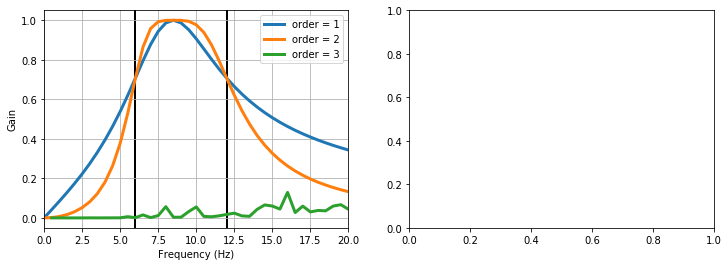

In [9]:
# test the filter for theta range.
f,ax = plt.subplots(1,2,figsize=(12,4))
iirFilt_coeffs = []
for ii, order in enumerate(iirFilt_order):
    b, a = butter_bandpass(lowcut, highcut, fs, order= order )
    iirFilt_coeffs.append((b,a))
    w, h = signal.freqz(b, a, worN=fs)
    plotFiltResp(ax[0],w,h, fs, order)
    if order==iirFilt_order[ii]:
        plotFitDetails(ax[0],lowcut,highcut)


clearly the iir butteworth is the best for this application

### test of ellipical filters:

No handles with labels found to put in legend.


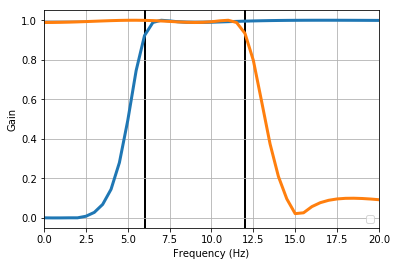

In [10]:
def ellip_low(lowcut, fs, order=2):
    return signal.ellip(order,0.1,60,lowcut/(fs/2),'highpass')

def ellip_high(highcut,fs,order=2):
    return signal.ellip(order,0.1,20,highcut/(fs/2),'lowpass')
lowcut = 6.5
highcut = 11.5

blow, alow = ellip_low(lowcut,fs,order=4)
bhigh, ahigh = ellip_high(highcut,fs,order=4)

w, h = signal.freqz(blow, alow, worN=fs)
f,ax=plt.subplots()
ax=plotFiltResp(ax,w,h,fs)

w, h = signal.freqz(bhigh, ahigh, worN=fs)
ax=plotFiltResp(ax,w,h,fs)

plotFitDetails(ax,6,12)


### Filter signal

In [11]:
filtCoeff = iirFilt_coeffs[1]
fsig = signal.filtfilt(filtCoeff[0],filtCoeff[1],sig)
fsig2 = signal.filtfilt(blow,alow,sig)
fsig2 = signal.filtfilt(bhigh,ahigh,fsig2)

In [12]:
freqs, PSig = signal.welch(sig, fs, nperseg=fs*2)
_, PfSig = signal.welch(fsig, fs, nperseg=fs*2)
_, PfSig2 = signal.welch(fsig2, fs, nperseg=fs*2)


(0.001, 20000)

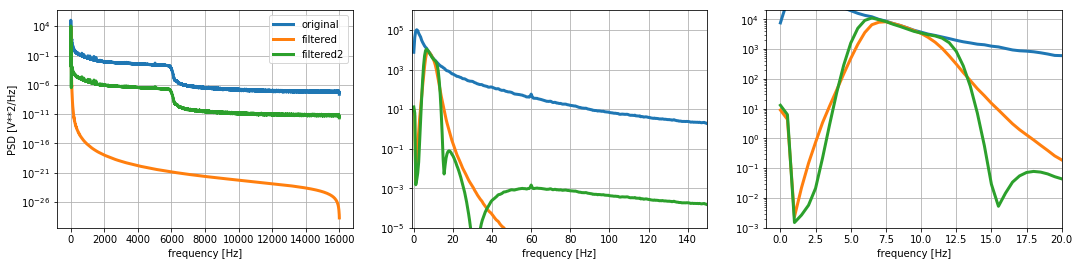

In [13]:
f,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].semilogy(freqs, PSig, linewidth = 3, label = 'original')
ax[0].semilogy(freqs, PfSig, linewidth = 3, label = 'filtered')
ax[0].semilogy(freqs, PfSig2, linewidth = 3, label = 'filtered2')

ax[0].grid(True)
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('PSD [V**2/Hz]')
ax[0].legend(loc='best')

ax[1].semilogy(freqs, PSig, linewidth = 3, label = 'original')
ax[1].semilogy(freqs, PfSig, linewidth = 3, label = 'filtered')
ax[1].semilogy(freqs, PfSig2, linewidth = 3, label = 'filtered2')
ax[1].grid(True)
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_xlim([-1,150])
ax[1].set_ylim([0.00001,1e6])

ax[2].semilogy(freqs, PSig, linewidth = 3, label = 'original')
ax[2].semilogy(freqs, PfSig, linewidth = 3, label = 'filtered')
ax[2].semilogy(freqs, PfSig2, linewidth = 3, label = 'filtered2')
ax[2].grid(True)
ax[2].set_xlabel('frequency [Hz]')
ax[2].set_xlim([-1,20])
ax[2].set_ylim([0.001,20000])



In [17]:
def plotSignalWindow(sig,start,winLength,ax=None):
    if not ax:
        f,ax=plt.subplots(figsize=(8,4))
    ax.plot(sig[start:(start+winLength)], linewidth = 2)
    ax.grid()
    return ax

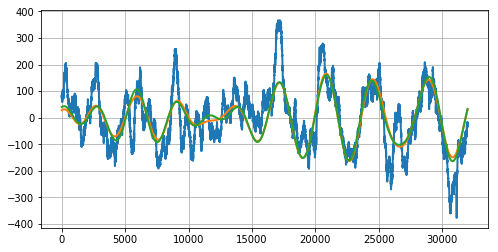

In [155]:
sec = 124
ax=plotSignalWindow(sig, fs*sec,fs)
ax=plotSignalWindow(fsig, fs*sec,fs,ax)
ax=plotSignalWindow(fsig2, fs*sec,fs,ax)

## get analytic signal

In [22]:
def Hilbert(sig):
    padding = np.zeros(int(2 ** np.ceil(np.log2(len(sig)))) - len(sig))
    tohilbert = np.hstack((sig, padding))
    
    result = signal.hilbert(tohilbert)    
    result = result[0:len(sig)]

    return result

In [23]:
asig = Hilbert(fsig2)

In [70]:
sigPower = np.abs(asig)
sigPhase = np.angle(asig)
sigFreq = np.diff(np.unwrap(sigPhase))/(2.0*np.pi)*fs

(0, 200)

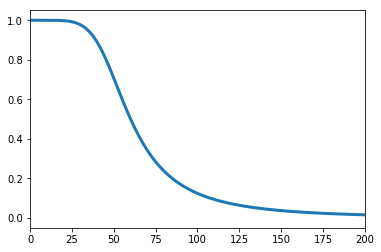

In [147]:
b,a = signal.butter(3,50/(fs/2),'lowpass')
w,h=signal.freqz(b,a,worN=fs)
f,ax=plt.subplots()
ax=plotFiltResp(ax,w,h,fs)
ax.set_xlim(0,200)

In [148]:
sigFreq2 = signal.filtfilt(b,a,sigFreq)

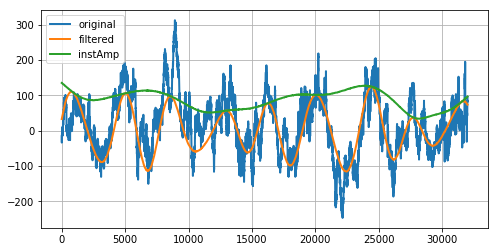

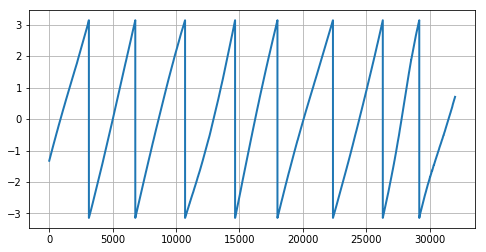

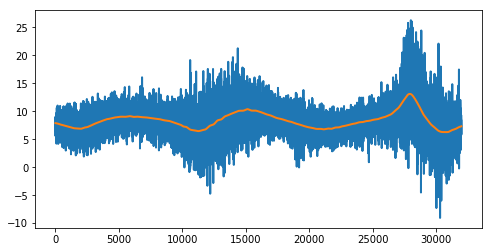

In [162]:
sec = 125
ax=plotSignalWindow(sig, fs*sec,fs)
ax=plotSignalWindow(fsig2, fs*sec,fs,ax)
ax=plotSignalWindow(sigPower, fs*sec,fs,ax)
ax.legend(labels=('original', 'filtered', 'instAmp'))
#ax=plotSignalWindow(sigPhase, fs*sec,fs,ax)
ax=plotSignalWindow(sigPhase, fs*sec,fs)
ax=plotSignalWindow(sigFreq, fs*sec,fs)
ax=plotSignalWindow(sigFreq2, fs*sec,fs,ax)


## Use decimated signal instead:

In [122]:
# get signal from 32kHz to 50; 32k/50 = 640; 10*8*8=640
dfs = 50
dsig = signal.decimate(sig,10)
dsig = signal.decimate(dsig,8)
dsig = signal.decimate(dsig,8)


No handles with labels found to put in legend.


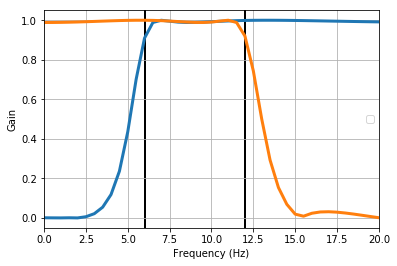

In [153]:
# create ellipsoid filter for decimated signal.
def ellip_low(lowcut, fs, order=2):
    return signal.ellip(order,0.1,60,lowcut/(fs/2),'highpass')

def ellip_high(highcut,fs,order=2):
    return signal.ellip(order,0.1,30,highcut/(fs/2),'lowpass')

lowcut = 6.5
highcut = 11.5

blow, alow = ellip_low(lowcut,dfs,order=4)
bhigh, ahigh = ellip_high(highcut,dfs,order=4)

w, h = signal.freqz(blow, alow, worN=dfs)
f,ax=plt.subplots()
ax=plotFiltResp(ax,w,h,dfs)

w, h = signal.freqz(bhigh, ahigh, worN=dfs)
ax=plotFiltResp(ax,w,h,dfs)

plotFitDetails(ax,6,12)

In [129]:
# filter
fdsig = signal.filtfilt(blow,alow,dsig)
fdsig = signal.filtfilt(bhigh,ahigh,fdsig)

(-1, 20)

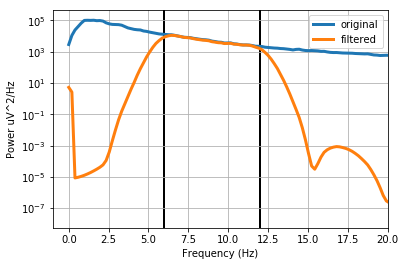

In [164]:
# Power Spectral density for the window of interest.
freqs, PdSig = signal.welch(dsig, dfs, nperseg=256)
freqs, PfdSig = signal.welch(fdsig, dfs, nperseg=256)

f,ax=plt.subplots()
ax.semilogy(freqs, PdSig, linewidth = 3, label = 'original')
ax.semilogy(freqs, PfdSig, linewidth = 3, label = 'filtered')
ax.grid(True)
ax.set_xlabel('frequency [Hz]')
plotFitDetails(ax,6,12)
ax.set_ylabel('Power uV^2/Hz')

ax.set_xlim([-1,20])

In [134]:
# get analytic signal.
d_asig = Hilbert(fdsig)

In [135]:
# obtain signals of interest from the analytic signal
dsigPower = np.abs(d_asig)
dsigPhase = np.angle(d_asig)
dsigFreq = np.diff(np.unwrap(dsigPhase))/(2.0*np.pi)*dfs

(0, 25)

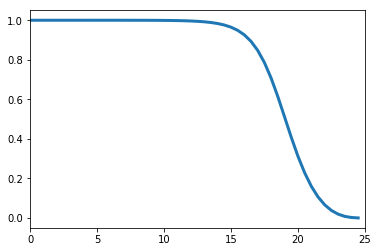

In [141]:
# lowpass filter for instatenous frequency
b,a = signal.butter(3,18/(dfs/2),'lowpass')
w,h=signal.freqz(b,a,worN=dfs)
f,ax=plt.subplots()
ax=plotFiltResp(ax,w,h,dfs)
ax.set_xlim(0,25)

In [140]:
# smooth instatenuous frequency
dsigFreq2 = signal.filtfilt(b,a,dsigFreq)

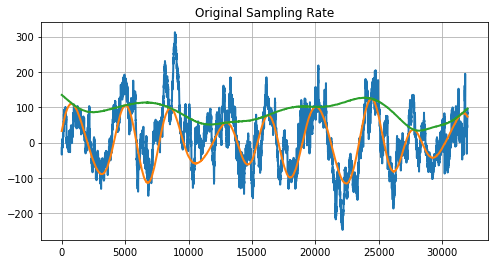

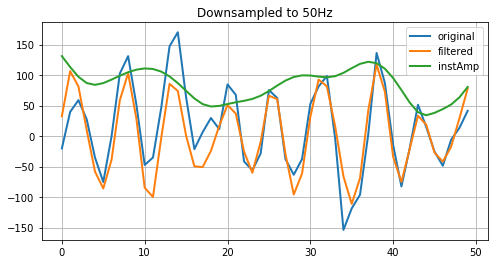

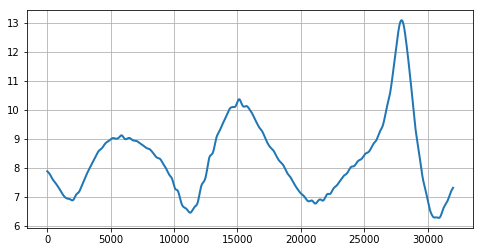

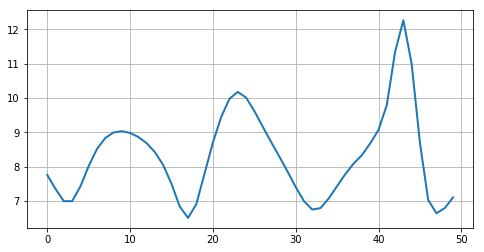

In [167]:
# plot a segment comparing signals at the different sampling rates
sec = 125

ax=plotSignalWindow(sig, fs*sec,fs)
ax=plotSignalWindow(fsig2, fs*sec,fs,ax)
ax=plotSignalWindow(sigPower, fs*sec,fs,ax)
ax.set_title('Original Sampling Rate')

ax=plotSignalWindow(dsig, dfs*sec,dfs)
ax=plotSignalWindow(fdsig, dfs*sec,dfs,ax)
ax=plotSignalWindow(dsigPower, dfs*sec,dfs,ax)
ax.legend(labels=('original', 'filtered', 'instAmp'))
ax.set_title('Downsampled to 50Hz')

ax=plotSignalWindow(sigFreq2, fs*sec,fs)
ax=plotSignalWindow(dsigFreq2, dfs*sec,dfs)
